# Dataset Overview

## Overview of the `dacapo_toolbox.iterable_dataset` helper function

The `iterable_dataset` function is a powerful helper function that wraps around
`gunpowder` and `funlib` libraries to provide a simple and powerful entrypoint
for creating torch datasets. It's main features are:
1. Properly handling spatial augmentations such as mirroring, transposing,
elastic deformations, rotations and image scaling while handling any
necessary context without excess padding or data reads. (This is a gunpowder feature)
See the [gunpowder docs](https://funkelab.github.io/gunpowder/) for more details.
2. Robust sampling of input data using a variety of sampling strategies such as
sampling from a set of points, guaranteeing a certain amount of masked in data,
or sampling uniformly from the input data. (This is also achieved using gunpowder)
3. Creates a simple torch dataset interface that can be used with any pytorch
parallelization scheme such as `torch.utils.data.DataLoader`.
4. Can handle both arrays and graphs as input and output data.
5. Can handle arbitrary number of dimensions, easily generalizing to 3D plus time.

In [1]:
# ## A simple dataset

from dacapo_toolbox.dataset import iterable_dataset
from funlib.persistence import Array
from skimage.data import astronaut
import matplotlib.pyplot as plt

from pathlib import Path

out_ds = Path("_static/dataset_overview")
if not out_ds.exists():
    out_ds.mkdir(parents=True)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

dataset = iterable_dataset(
    {"astronaut": Array(astronaut().transpose((2, 0, 1)), voxel_size=(1, 1))},
    shapes={"astronaut": (256, 256)},
)
batch_gen = iter(dataset)

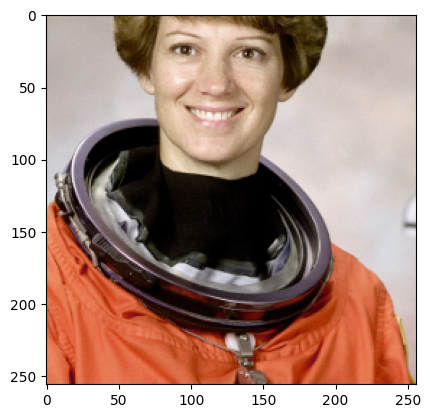

In [3]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

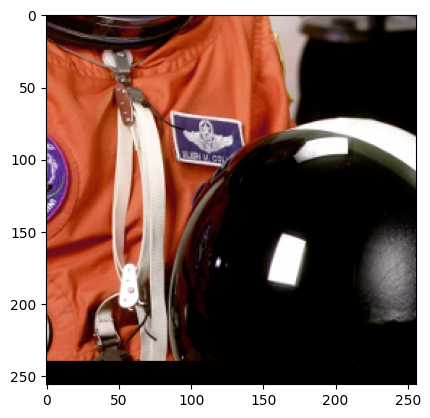

In [4]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

You may notice a couple things about the above images.

First why are we transposing and adding a voxel size? `Gunpowder` expects channel dimensions
to come before spatial dimensions, and the voxel size defines the number of spatial channels.
Allowing for a voxel size lets us handle arrays of different resolutions and makes sure we can
handle any non-isotropic data gracefully.

Second we see some padding at the side. This is because we treat every array given to us
as an infinite array padded with zeros, and by default only guarantee that the center pixel is
sampled from within the provided array. You can adjust this with the `trim` term.

In [5]:

dataset = iterable_dataset(
    {"astronaut": Array(astronaut().transpose((2, 0, 1)), voxel_size=(1, 1))},
    shapes={"astronaut": (256, 256)},
    trim=(128, 128),
)
batch_gen = iter(dataset)

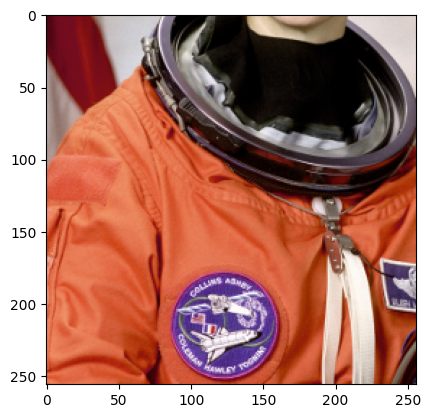

In [6]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

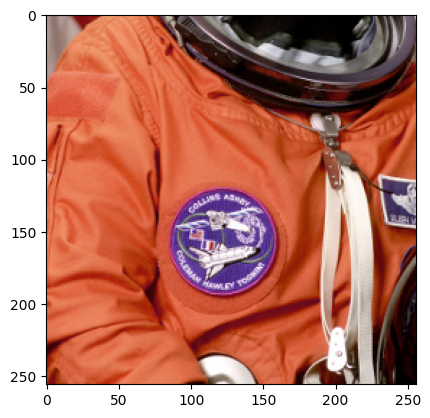

In [7]:
sample = next(batch_gen)

plt.imshow(sample["astronaut"].numpy().transpose((1, 2, 0)))
plt.show()

Now since we trim, we make sure we only choose samples where the
center pixel is at least `trim` pixels away from the edge of the image.
This guarantees that we don't get samples with padding, but this may lead
to errors if your training data is smaller than `2*trim`

Next lets add more arrays. Maybe you have multiple datasets, and multiple
arrays per dataset.

In [8]:
from skimage.data import coffee

astronaut_data = astronaut().transpose((2, 0, 1)) / 255
coffee_data = coffee().transpose((2, 0, 1)) / 255

dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
        "mask": [
            Array(
                astronaut_data[0] > (astronaut_data[1] + astronaut_data[2])
            ),  # mask in red regions
            Array(
                coffee_data[0] > (coffee_data[1] + coffee_data[2])
            ),  # mask in red regions
        ],
    },
    shapes={"image": (256, 256), "mask": (256, 256)},
)
batch_gen = iter(dataset)

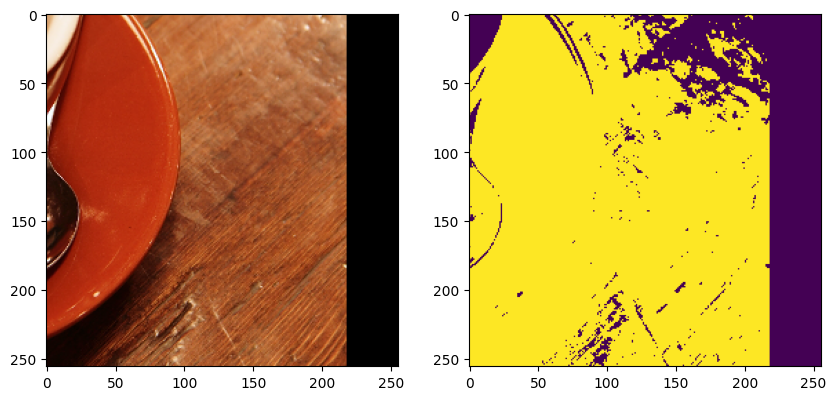

In [9]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
plt.show()

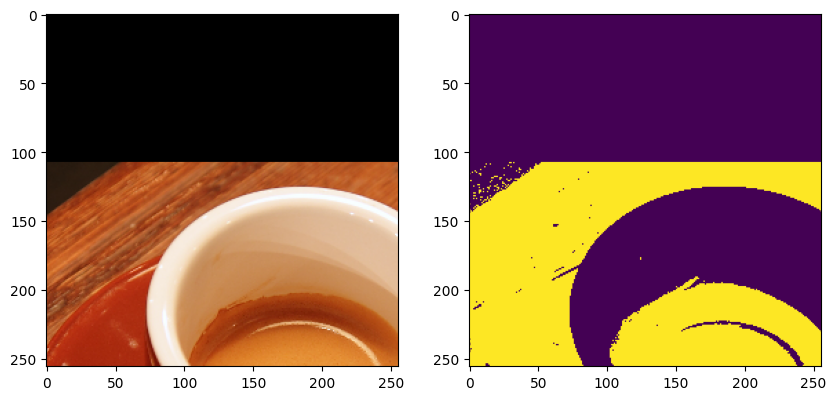

In [10]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
plt.show()

Lets add a graph to the dataset. We use the `networkx` library
to interface with graphs. Each node in the graph must have a `position`
attribute in *world coordinates*, this means accounting for the
voxel size of the arrays given. In our case voxel size is (1, 1) so
we can just use the pixel coordinates. We'll use a simple grid of points as our graph.

In [11]:
import networkx as nx
from itertools import product


def gen_graphs():
    graphs = []
    for img_data in [astronaut_data, coffee_data]:
        graph = nx.Graph()
        for i, j in product(
            range(0, img_data.shape[1], 32), range(0, img_data.shape[2], 32)
        ):
            graph.add_node(i * img_data.shape[2] + j, position=(i + 0.5, j + 0.5))
        graphs.append(graph)
    return graphs

In [12]:
# Lets request the graph in a smaller region. It will be centered within the data
# we ask for.

In [13]:

dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
        "mask": [
            Array(
                astronaut_data[0] > (astronaut_data[1] + astronaut_data[2])
            ),  # mask in red regions
            Array(
                coffee_data[0] > (coffee_data[1] + coffee_data[2])
            ),  # mask in red regions
        ],
        "graph": gen_graphs(),
    },
    shapes={"image": (256, 256), "mask": (256, 256), "graph": (128, 128)},
)
batch_gen = iter(dataset)

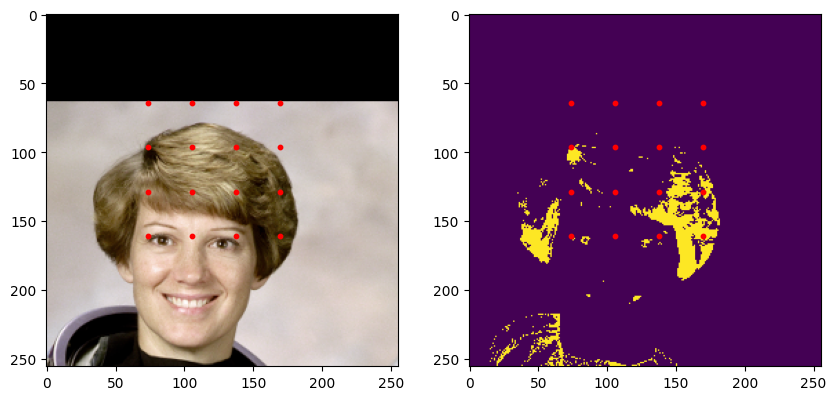

In [14]:
import numpy as np

sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[0].scatter(ys, xs, c="red", s=10)
ax[1].imshow(sample["mask"].numpy())
ax[1].scatter(ys, xs, c="red", s=10)
plt.show()

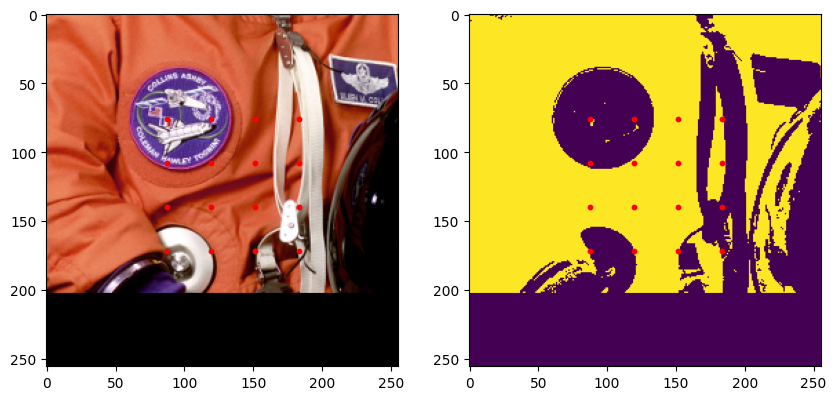

In [15]:
sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[0].scatter(ys, xs, c="red", s=10)
ax[1].imshow(sample["mask"].numpy())
ax[1].scatter(ys, xs, c="red", s=10)
plt.show()

## Augmentations/Transformations

We almost always want to transform our data in some way. The `iterable_dataset`
differentiates between two types of transformations:
1. **Spatial augmentations**: These are augmentations that change the spatial
   properties of the data. For example, mirroring, transposing, elastic deformations.
2. **Non-spatial augmentations**: These are augmentations that operate on the image
   content itself. For example, adding noise, changing brightness, binarizing, etc.

### Spatial augmentations

We take two config classes that parameterize the spatial augmentations we support.
`DeformAugmentConfig`, and `SimpleAugmentConfig`.
1. The `DeformAugmentConfig` handles continuous transforms requiring interpolation.
This includes rotation, scaling and elastically deforming.
2. The `SimpleAugmentConfig` handles discrete transforms that don't require interpolation.
This includes mirroring and transposing.

In [16]:
from dacapo_toolbox.dataset import DeformAugmentConfig, SimpleAugmentConfig


dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
        "graph": gen_graphs(),
    },
    shapes={"image": (256, 256), "graph": (128, 128)},
    simple_augment_config=SimpleAugmentConfig(p=1.0, mirror_only=[1]),
    deform_augment_config=DeformAugmentConfig(
        p=1.0,
        control_point_spacing=(8, 8),
        jitter_sigma=(8.0, 8.0),
        scale_interval=(0.5, 2.0),
        rotate=True,
    ),
)
batch_gen = iter(dataset)

/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/scipy/ndimage/_measurements.py:1550: RuntimeWarning: invalid value encountered in divide
  results = [sum_labels(input * grids[dir].astype(float), labels, index) / normalizer


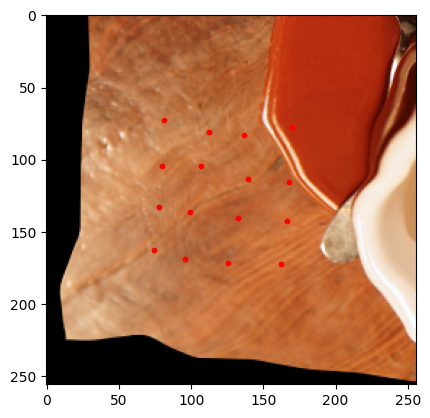

In [17]:
sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

plt.imshow(sample["image"].numpy().transpose((1, 2, 0)))
plt.scatter(ys, xs, c="red", s=10)
plt.show()

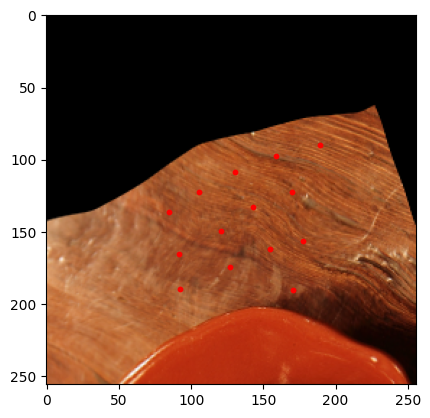

In [18]:
sample = next(batch_gen)

graph = sample["graph"]
xs = np.array([attrs["position"][0] for attrs in graph.nodes.values()])
ys = np.array([attrs["position"][1] for attrs in graph.nodes.values()])

plt.imshow(sample["image"].numpy().transpose((1, 2, 0)))
plt.scatter(ys, xs, c="red", s=10)
plt.show()

### Non-spatial augmentations

Non-spatial augmentations are handled using the `transforms` argument to the
`iterable_dataset` function. This is a dictionary of tuples, where the key is
a tuple of input and output keys, and the value is a callable that takes the
designated inputs, and generates the designated outputs.

e.g. `(("a", "b"), ("c", "d")): transform_1` means we expect `transform_1` to take
2 tensors in ("a", "b"), and produce 2 tensors ("c", "d").

`("a", "c"): transform_2` is short hand for a transform that takes a single tensor
in and outputs a single tensor.

`"a": transform_3` is short hand for a transform that takes in a single tensor and
produces a single tensor that should replace the input tensor.

Lets see some examples:

In [19]:
from torchvision.transforms import v2 as transforms

dataset = iterable_dataset(
    {
        "image": [
            Array(astronaut_data, voxel_size=(1, 1)),
            Array(coffee_data, voxel_size=(1, 1)),
        ],
    },
    transforms={
        "image": transforms.GaussianBlur(3, sigma=(2.0, 2.0)),
        ("image", "mask"): lambda d: d[0] > d[1] + d[2],  # mask in red regions
        (("mask", "image"), "masked_image"): lambda mask, image: mask * image,
    },
    shapes={"image": (256, 256)},
)
batch_gen = iter(dataset)

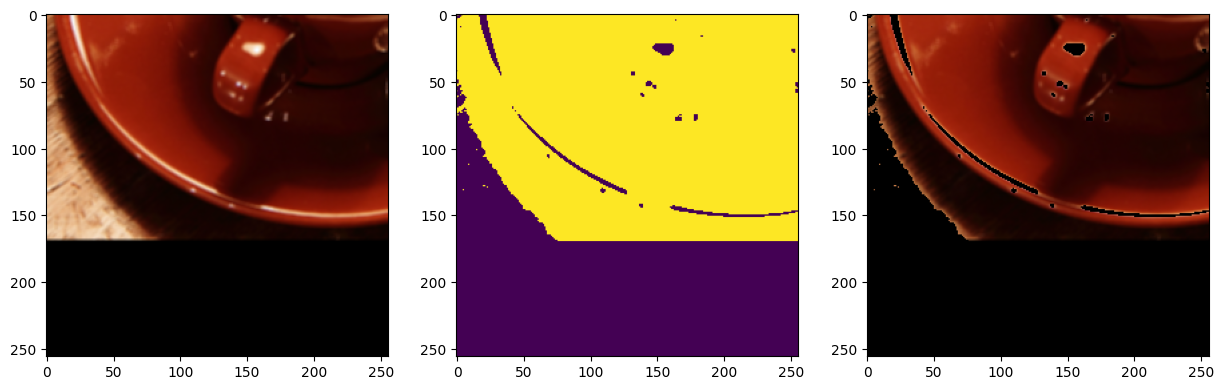

In [20]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
ax[2].imshow(sample["masked_image"].numpy().transpose((1, 2, 0)))
plt.show()

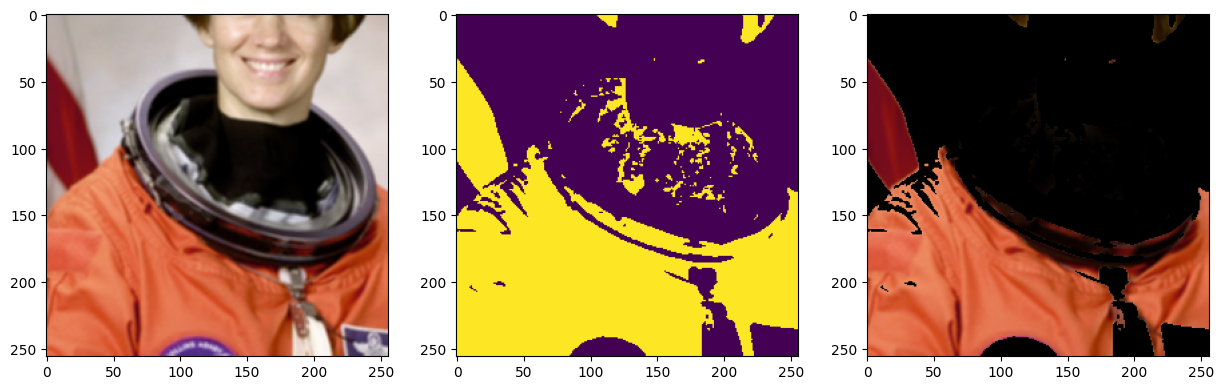

In [21]:
sample = next(batch_gen)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample["image"].numpy().transpose((1, 2, 0)))
ax[1].imshow(sample["mask"].numpy())
ax[2].imshow(sample["masked_image"].numpy().transpose((1, 2, 0)))
plt.show()

DEBUG:gunpowder.array:Registering array key raw_s0


DEBUG:gunpowder.array:Registering array key gt_s0


DEBUG:gunpowder.array:Registering array key raw_s1


DEBUG:gunpowder.array:Registering array key gt_s1


DEBUG:gunpowder.array:Registering array key mask


DEBUG:gunpowder.array:Registering array key mask_dummy


DEBUG:gunpowder.graph:Registering graph type sample_points


DEBUG:gunpowder.array:Registering array key ROI_MASK


DEBUG:gunpowder.graph:Trying to create a Graph without specifying directionality. Using default Directed!


DEBUG:gunpowder.array:Registering array key mask_dummy


DEBUG:gunpowder.array:Registering array key mask_dummy


DEBUG:gunpowder.graph:Trying to create a Graph without specifying directionality. Using default Directed!


DEBUG:gunpowder.graph:Registering graph type sample_points


DEBUG:gunpowder.graph:Registering graph type sample_points


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides raw_s0 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates raw_s0 with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides gt_s0 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates gt_s0 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides raw_s1 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates raw_s1 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides gt_s1 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates gt_s1 with ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides mask with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates mask with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides mask_dummy with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates mask_dummy with ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of GraphSource:
None


DEBUG:gunpowder.nodes.batch_provider:GraphSource provides sample_points with spec ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides ROI_MASK with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:
None


DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides raw_s0 with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides gt_s0 with spec ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides raw_s1 with spec ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides gt_s1 with spec ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides mask with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides mask_dummy with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides sample_points with spec ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	sample_points: ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides ROI_MASK with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False


INFO:gunpowder.nodes.random_location:requesting complete mask...


DEBUG:gunpowder.nodes.batch_provider:MergeProvider got request 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (2048, 2048) from [0:2048, 0:2048] (2048, 2048) to [0:2048, 0:2048] (2048, 2048)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



INFO:gunpowder.nodes.random_location:allocating mask integral array...


DEBUG:gunpowder.nodes.random_location:mask size is 4194304


DEBUG:gunpowder.nodes.random_location:chose <class 'numpy.uint32'> as integral array dtype


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates raw_s0 with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates gt_s0 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates raw_s1 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates gt_s1 with ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates mask with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates mask_dummy with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates ROI_MASK with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates sample_points with ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides raw_s0 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates raw_s0 with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides gt_s0 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates gt_s0 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides raw_s1 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates raw_s1 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides gt_s1 with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates gt_s1 with ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides mask with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates mask with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides mask_dummy with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:Pad updates mask_dummy with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of GraphSource:
None


DEBUG:gunpowder.nodes.batch_provider:GraphSource provides sample_points with spec ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of ArraySource:
None


DEBUG:gunpowder.nodes.batch_provider:ArraySource provides ROI_MASK with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:
None


DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides raw_s0 with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides gt_s0 with spec ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides raw_s1 with spec ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides gt_s1 with spec ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides mask with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides mask_dummy with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides sample_points with spec ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of MergeProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	sample_points: ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides ROI_MASK with spec ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False


INFO:gunpowder.nodes.random_location:requesting all sample_points points...


DEBUG:gunpowder.nodes.batch_provider:MergeProvider got request 
	sample_points: ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource got request 
	sample_points: ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource provides 
	sample_points: ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides 
	sample_points: ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.random_location:retrieved 4 points


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates raw_s0 with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates gt_s0 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates raw_s1 with ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates gt_s1 with ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates mask with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates mask_dummy with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates ROI_MASK with ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False


DEBUG:gunpowder.nodes.batch_filter:RandomLocation updates sample_points with ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:
None


DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides raw_s0 with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides gt_s0 with spec ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides raw_s1 with spec ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides gt_s1 with spec ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides mask with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides mask_dummy with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides ROI_MASK with spec ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:Current spec of RandomProvider:

	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides sample_points with spec ROI: [:, :] (inf, inf), dtype: <class 'numpy.float32'>, directed: None, placeholder: False


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.simple_augment:mirror = [True, False]


DEBUG:gunpowder.nodes.simple_augment:transpose = [0, 1]


DEBUG:gunpowder.nodes.simple_augment:downstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sam

DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sampl

DEBUG:gunpowder.nodes.batch_provider:DeformAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.deform_augment:total ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI aligned with control points is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI in control point spacing is [-1:65, -1:65] (66, 66)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s0 = [-314:928, -319:938] (1242, 1257)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s0 = [-314:928, -320:938] (1242, 1258)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s1 = [-314:928, -320:938] (1242, 1258)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s1 = [-316:928, -320:936] (1244, 1256)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask = [-314:928, -319:938] (1242, 1257)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask_dummy = [-7:620, -8:623] (627, 631)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for ROI_MASK = [303:305, 305:307] (2, 2)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for sample_points = [-315:929, -321:939] (1244, 1260)


DEBUG:gunpowder.nodes.batch_provider:RandomProvider got request 
	raw_s0: ROI: [-314:928, -319:938] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-314:928, -320:938] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-314:928, -320:938] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-316:928, -320:936] (1244, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-314:928, -319:938] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [-7:620, -8:623] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [303:305, 305:307] (2, 2), voxel size: None, interpolatable: None, non-spatial:

DEBUG:gunpowder.nodes.batch_provider:RandomLocation got request 
	raw_s0: ROI: [-314:928, -319:938] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-314:928, -320:938] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-314:928, -320:938] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-316:928, -320:936] (1244, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-314:928, -319:938] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [-7:620, -8:623] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [303:305, 305:307] (2, 2), voxel size: None, interpolatable: None, non-spatial:

DEBUG:gunpowder.nodes.random_location:request: {raw_s0: ROI: [-314:928, -319:938] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s0: ROI: [-314:928, -320:938] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, raw_s1: ROI: [-314:928, -320:938] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s1: ROI: [-316:928, -320:936] (1244, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask: ROI: [-314:928, -319:938] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask_dummy: ROI: [-7:620, -8:623] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, ROI_MASK: ROI: [303:305, 305:307] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.random_location:my spec: 
	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False
	sample_points: ROI: [:, :] (inf, inf), dtype: <cl

DEBUG:gunpowder.nodes.random_location:valid shifts for request in [7:1432, 8:1429] (1425, 1421)


DEBUG:gunpowder.nodes.random_location:restricting random locations to multiples of voxel size (4, 4)


DEBUG:gunpowder.nodes.random_location:random shift: (596, 996)


DEBUG:gunpowder.nodes.random_location:mask ratio is 0.693780


DEBUG:gunpowder.nodes.random_location:random location does not meet 'min_masked' criterium


DEBUG:gunpowder.nodes.random_location:random shift: (1416, 1364)


DEBUG:gunpowder.nodes.random_location:mask ratio is 0.000000


DEBUG:gunpowder.nodes.random_location:random location does not meet 'min_masked' criterium


DEBUG:gunpowder.nodes.random_location:random shift: (1152, 708)


DEBUG:gunpowder.nodes.random_location:mask ratio is 0.000000


DEBUG:gunpowder.nodes.random_location:random location does not meet 'min_masked' criterium


DEBUG:gunpowder.nodes.random_location:random shift: (1336, 640)


DEBUG:gunpowder.nodes.random_location:mask ratio is 0.000000


DEBUG:gunpowder.nodes.random_location:random location does not meet 'min_masked' criterium


DEBUG:gunpowder.nodes.random_location:random shift: (196, 660)


DEBUG:gunpowder.nodes.random_location:mask ratio is 1.000000


DEBUG:gunpowder.nodes.batch_provider:MergeProvider got request 
	raw_s0: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-120:1124, 340:1596] (1244, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [499:501, 965:967] (2, 2), voxel size: None, interpolatable: None, non-s

DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s0: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s0: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s0: ROI: [0:1124, 341:1598] (1124, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s0: ROI: [0:1124, 341:1598] (1124, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s0: ROI: [0:1124, 341:1598] (1124, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (1124, 1257) from [0:1124, 341:1598] (1124, 1257) to [-118:1124, 341:1598] (1242, 1257)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s0: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s0: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s0: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s0: ROI: [0:1124, 340:1598] (1124, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s0: ROI: [0:1124, 340:1598] (1124, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s0: ROI: [0:1124, 340:1598] (1124, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (562, 629) from [0:562, 170:799] (562, 629) to [-59:562, 170:799] (621, 629)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s0: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s1: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s1: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s1: ROI: [0:1124, 340:1598] (1124, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s1: ROI: [0:1124, 340:1598] (1124, 1258), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s1: ROI: [0:1124, 340:1598] (1124, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (562, 629) from [0:562, 170:799] (562, 629) to [-59:562, 170:799] (621, 629)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s1: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s1: ROI: [-120:1124, 340:1596] (1244, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s1: ROI: [-120:1124, 340:1596] (1244, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s1: ROI: [0:1124, 340:1596] (1124, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s1: ROI: [0:1124, 340:1596] (1124, 1256), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s1: ROI: [0:1124, 340:1596] (1124, 1256), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (281, 314) from [0:281, 85:399] (281, 314) to [-30:281, 85:399] (311, 314)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s1: ROI: [-120:1124, 340:1596] (1244, 1256), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask: ROI: [0:1124, 341:1598] (1124, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask: ROI: [0:1124, 341:1598] (1124, 1257), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask: ROI: [0:1124, 341:1598] (1124, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (1124, 1257) from [0:1124, 341:1598] (1124, 1257) to [-118:1124, 341:1598] (1242, 1257)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (627, 631) from [189:816, 652:1283] (627, 631) to [189:816, 652:1283] (627, 631)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	ROI_MASK: ROI: [499:501, 965:967] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	ROI_MASK: ROI: [499:501, 965:967] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource got request 
	sample_points: ROI: [-119:1125, 339:1599] (1244, 1260), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource provides 
	sample_points: ROI: [-119:1125, 339:1599] (1244, 1260), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides 
	raw_s0: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-118:1124, 340:1598] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-120:1124, 340:1596] (1244, 1256), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-118:1124, 341:1598] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [189:816, 652:1283] (627, 631), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [499:501, 965:967] (2, 2), voxel size: (1, 1), interpol

DEBUG:gunpowder.nodes.batch_provider:RandomLocation provides 
	raw_s0: ROI: [-314:928, -319:938] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-314:928, -320:938] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-314:928, -320:938] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-316:928, -320:936] (1244, 1256), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-314:928, -319:938] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [-7:620, -8:623] (627, 631), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [303:305, 305:307] (2, 2), voxel size: (1, 1), interpolatable:

DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides 
	raw_s0: ROI: [-314:928, -319:938] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-314:928, -320:938] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-314:928, -320:938] (1242, 1258), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-316:928, -320:936] (1244, 1256), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-314:928, -319:938] (1242, 1257), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [-7:620, -8:623] (627, 631), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [303:305, 305:307] (2, 2), voxel size: (1, 1), interpolatable:

DEBUG:gunpowder.nodes.deform_augment:Cropping graph to target roi [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.batch_provider:DeformAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:transposed mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream ROI_MASK ROI = [319:320, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:mirrored ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:transposed ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:augmenting in [0:640, 0:640] (640, 640) and center (320, 320)


DEBUG:gunpowder.nodes.simple_augment:converting nodes in graph sample_points


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:dacapo_toolbox.dataset:Batch generated in 0.6912 seconds


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBolIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Medium.ttf', name='Lato', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 0.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', name='Liberation Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Heavy.ttf', name='Lato', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-ExtraLight.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=200, stretch='normal', size='scalable')) = 0.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Light.ttf', name='Lato', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Semibold.ttf', name='Lato', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf', name='Liberation Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-SemiboldItalic.ttf', name='Lato', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-LightItalic.ttf', name='Lato', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', name='Liberation Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Bold.ttf', name='Lato', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-HairlineItalic.ttf', name='Lato', style='italic', variant='normal', weight=250, stretch='normal', size='scalable')) = 11.1925


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', name='Liberation Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-HeavyItalic.ttf', name='Lato', style='italic', variant='normal', weight=800, stretch='normal', size='scalable')) = 11.43


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='scalable')) = 1.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', name='Liberation Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuMathTeXGyre.ttf', name='DejaVu Math TeX Gyre', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-BlackItalic.ttf', name='Lato', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) = 11.525


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-BoldItalic.ttf', name='Lato', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Thin.ttf', name='Lato', style='normal', variant='normal', weight=275, stretch='normal', size='scalable')) = 10.16875


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Italic.ttf', name='Lato', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-MediumItalic.ttf', name='Lato', style='italic', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 0.5349999999999999


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Hairline.ttf', name='Lato', style='normal', variant='normal', weight=250, stretch='normal', size='scalable')) = 10.1925


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Regular.ttf', name='Lato', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='condensed', size='scalable')) = 1.535


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-ThinItalic.ttf', name='Lato', style='italic', variant='normal', weight=275, stretch='normal', size='scalable')) = 11.16875


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf', name='Liberation Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lato/Lato-Black.ttf', name='Lato', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/runner/work/dacapo-toolbox/dacapo-toolbox/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.


Batch 0


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.simple_augment:mirror = [True, False]


DEBUG:gunpowder.nodes.simple_augment:transpose = [0, 1]


DEBUG:gunpowder.nodes.simple_augment:downstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sam

DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sampl

DEBUG:gunpowder.nodes.batch_provider:DeformAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.deform_augment:total ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI aligned with control points is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI in control point spacing is [-1:65, -1:65] (66, 66)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s0 = [-197:836, -191:834] (1033, 1025)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s0 = [-196:838, -190:836] (1034, 1026)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s1 = [-196:838, -190:836] (1034, 1026)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s1 = [-196:840, -188:840] (1036, 1028)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask = [-197:836, -191:834] (1033, 1025)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask_dummy = [60:580, 57:576] (520, 519)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for ROI_MASK = [320:322, 313:315] (2, 2)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for sample_points = [-198:838, -191:836] (1036, 1027)


DEBUG:gunpowder.nodes.batch_provider:RandomProvider got request 
	raw_s0: ROI: [-197:836, -191:834] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-196:838, -190:836] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-196:838, -190:836] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-196:840, -188:840] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-197:836, -191:834] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [60:580, 57:576] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:322, 313:315] (2, 2), voxel size: None, interpolatable: None, non-spatial:

DEBUG:gunpowder.nodes.batch_provider:RandomLocation got request 
	raw_s0: ROI: [-197:836, -191:834] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-196:838, -190:836] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-196:838, -190:836] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-196:840, -188:840] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-197:836, -191:834] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [60:580, 57:576] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:322, 313:315] (2, 2), voxel size: None, interpolatable: None, non-spatial:

DEBUG:gunpowder.nodes.random_location:request: {raw_s0: ROI: [-197:836, -191:834] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s0: ROI: [-196:838, -190:836] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, raw_s1: ROI: [-196:838, -190:836] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s1: ROI: [-196:840, -188:840] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask: ROI: [-197:836, -191:834] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask_dummy: ROI: [60:580, 57:576] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, ROI_MASK: ROI: [320:322, 313:315] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.random_location:my spec: 
	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False
	sample_points: ROI: [:, :] (inf, inf), dtype: <cl

DEBUG:gunpowder.nodes.random_location:valid shifts for request in [-60:1472, -57:1476] (1532, 1533)


DEBUG:gunpowder.nodes.random_location:restricting random locations to multiples of voxel size (4, 4)


DEBUG:gunpowder.nodes.random_location:random shift: (1072, 880)


DEBUG:gunpowder.nodes.random_location:mask ratio is 0.000000


DEBUG:gunpowder.nodes.random_location:random location does not meet 'min_masked' criterium


DEBUG:gunpowder.nodes.random_location:random shift: (228, 460)


DEBUG:gunpowder.nodes.random_location:mask ratio is 1.000000


DEBUG:gunpowder.nodes.batch_provider:MergeProvider got request 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [548:550, 773:775] (2, 2), voxel size: None, interpolatable: None, non-spatial: Fa

DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (1033, 1025) from [31:1064, 269:1294] (1033, 1025) to [31:1064, 269:1294] (1033, 1025)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (517, 513) from [16:533, 135:648] (517, 513) to [16:533, 135:648] (517, 513)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (517, 513) from [16:533, 135:648] (517, 513) to [16:533, 135:648] (517, 513)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (259, 257) from [8:267, 68:325] (259, 257) to [8:267, 68:325] (259, 257)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (1033, 1025) from [31:1064, 269:1294] (1033, 1025) to [31:1064, 269:1294] (1033, 1025)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (520, 519) from [288:808, 517:1036] (520, 519) to [288:808, 517:1036] (520, 519)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	ROI_MASK: ROI: [548:550, 773:775] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	ROI_MASK: ROI: [548:550, 773:775] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource got request 
	sample_points: ROI: [30:1066, 269:1296] (1036, 1027), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource provides 
	sample_points: ROI: [30:1066, 269:1296] (1036, 1027), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides 
	raw_s0: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [32:1066, 270:1296] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [32:1068, 272:1300] (1036, 1028), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [31:1064, 269:1294] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [288:808, 517:1036] (520, 519), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [548:550, 773:775] (2, 2), voxel size: (1, 1), interpolatable: No

DEBUG:gunpowder.nodes.batch_provider:RandomLocation provides 
	raw_s0: ROI: [-197:836, -191:834] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-196:838, -190:836] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-196:838, -190:836] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-196:840, -188:840] (1036, 1028), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-197:836, -191:834] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [60:580, 57:576] (520, 519), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [320:322, 313:315] (2, 2), voxel size: (1, 1), interpolatable:

DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides 
	raw_s0: ROI: [-197:836, -191:834] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-196:838, -190:836] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-196:838, -190:836] (1034, 1026), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-196:840, -188:840] (1036, 1028), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-197:836, -191:834] (1033, 1025), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [60:580, 57:576] (520, 519), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [320:322, 313:315] (2, 2), voxel size: (1, 1), interpolatable:

DEBUG:gunpowder.nodes.deform_augment:Cropping graph to target roi [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.batch_provider:DeformAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:transposed mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream ROI_MASK ROI = [319:320, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:mirrored ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:transposed ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:augmenting in [0:640, 0:640] (640, 640) and center (320, 320)


DEBUG:gunpowder.nodes.simple_augment:converting nodes in graph sample_points


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:dacapo_toolbox.dataset:Batch generated in 0.6836 seconds


Batch 1


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.simple_augment:mirror = [True, False]


DEBUG:gunpowder.nodes.simple_augment:transpose = [0, 1]


DEBUG:gunpowder.nodes.simple_augment:downstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sam

DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sampl

DEBUG:gunpowder.nodes.batch_provider:DeformAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.deform_augment:total ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI aligned with control points is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI in control point spacing is [-1:65, -1:65] (66, 66)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s0 = [-186:818, -194:819] (1004, 1013)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s0 = [-186:818, -194:820] (1004, 1014)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s1 = [-186:818, -194:820] (1004, 1014)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s1 = [-188:820, -196:820] (1008, 1016)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask = [-186:818, -194:819] (1004, 1013)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask_dummy = [58:569, 58:569] (511, 511)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for ROI_MASK = [309:311, 312:314] (2, 2)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for sample_points = [-188:819, -196:820] (1007, 1016)


DEBUG:gunpowder.nodes.batch_provider:RandomProvider got request 
	raw_s0: ROI: [-186:818, -194:819] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-186:818, -194:820] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-186:818, -194:820] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-188:820, -196:820] (1008, 1016), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-186:818, -194:819] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [58:569, 58:569] (511, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [309:311, 312:314] (2, 2), voxel size: None, interpolatable: None, non-spatial:

DEBUG:gunpowder.nodes.batch_provider:RandomLocation got request 
	raw_s0: ROI: [-186:818, -194:819] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-186:818, -194:820] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-186:818, -194:820] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-188:820, -196:820] (1008, 1016), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-186:818, -194:819] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [58:569, 58:569] (511, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [309:311, 312:314] (2, 2), voxel size: None, interpolatable: None, non-spatial:

DEBUG:gunpowder.nodes.random_location:request: {raw_s0: ROI: [-186:818, -194:819] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s0: ROI: [-186:818, -194:820] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, raw_s1: ROI: [-186:818, -194:820] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s1: ROI: [-188:820, -196:820] (1008, 1016), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask: ROI: [-186:818, -194:819] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask_dummy: ROI: [58:569, 58:569] (511, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, ROI_MASK: ROI: [309:311, 312:314] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.random_location:my spec: 
	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False
	sample_points: ROI: [:, :] (inf, inf), dtype: <cl

DEBUG:gunpowder.nodes.random_location:valid shifts for request in [-309:1741, -312:1738] (2050, 2050)


DEBUG:gunpowder.nodes.random_location:restricting random locations to multiples of voxel size (4, 4)


DEBUG:gunpowder.nodes.random_location:select random point at [2047.75 2047.75]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (511, 511)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-188:819, -196:820] (1007, 1016)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (251, 254)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [434:435, 434:435] (1, 1)


DEBUG:gunpowder.nodes.random_location:reject random shift, random point [2047.75 2047.75] shift ROI [434:435, 434:435] (1, 1) does not intersect total shift ROI [-77:435, -78:434] (512, 512)


DEBUG:gunpowder.nodes.random_location:select random point at [0.25 0.25]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (0, 0)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-188:819, -196:820] (1007, 1016)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (251, 254)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [-77:-76, -77:-76] (1, 1)


DEBUG:gunpowder.nodes.random_location:random shift: (-308, -308)


DEBUG:gunpowder.nodes.random_location:random shift: (-308, -308)


DEBUG:gunpowder.nodes.batch_provider:MergeProvider got request 
	raw_s0: ROI: [-494:510, -502:511] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-494:510, -502:512] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-494:510, -502:512] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-496:512, -504:512] (1008, 1016), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-494:510, -502:511] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [-250:261, -250:261] (511, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [1:3, 4:6] (2, 2), voxel size: None, interpolatable: None, non-spatial: Fals

DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s0: ROI: [-494:510, -502:511] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s0: ROI: [-494:510, -502:511] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s0: ROI: [0:510, 0:511] (510, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s0: ROI: [0:510, 0:511] (510, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s0: ROI: [0:510, 0:511] (510, 511), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (510, 511) from [0:510, 0:511] (510, 511) to [-494:510, -502:511] (1004, 1013)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s0: ROI: [-494:510, -502:511] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s0: ROI: [-494:510, -502:512] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s0: ROI: [-494:510, -502:512] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s0: ROI: [0:510, 0:512] (510, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s0: ROI: [0:510, 0:512] (510, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s0: ROI: [0:510, 0:512] (510, 512), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (255, 256) from [0:255, 0:256] (255, 256) to [-247:255, -251:256] (502, 507)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s0: ROI: [-494:510, -502:512] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s1: ROI: [-494:510, -502:512] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s1: ROI: [-494:510, -502:512] (1004, 1014), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s1: ROI: [0:510, 0:512] (510, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s1: ROI: [0:510, 0:512] (510, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s1: ROI: [0:510, 0:512] (510, 512), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (255, 256) from [0:255, 0:256] (255, 256) to [-247:255, -251:256] (502, 507)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s1: ROI: [-494:510, -502:512] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s1: ROI: [-496:512, -504:512] (1008, 1016), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s1: ROI: [-496:512, -504:512] (1008, 1016), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s1: ROI: [0:512, 0:512] (512, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s1: ROI: [0:512, 0:512] (512, 512), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s1: ROI: [0:512, 0:512] (512, 512), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (128, 128) from [0:128, 0:128] (128, 128) to [-124:128, -126:128] (252, 254)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s1: ROI: [-496:512, -504:512] (1008, 1016), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask: ROI: [-494:510, -502:511] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask: ROI: [-494:510, -502:511] (1004, 1013), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask: ROI: [0:510, 0:511] (510, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask: ROI: [0:510, 0:511] (510, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask: ROI: [0:510, 0:511] (510, 511), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (510, 511) from [0:510, 0:511] (510, 511) to [-494:510, -502:511] (1004, 1013)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask: ROI: [-494:510, -502:511] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask_dummy: ROI: [-250:261, -250:261] (511, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask_dummy: ROI: [-250:261, -250:261] (511, 511), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask_dummy: ROI: [0:261, 0:261] (261, 261), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask_dummy: ROI: [0:261, 0:261] (261, 261), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask_dummy: ROI: [0:261, 0:261] (261, 261), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (261, 261) from [0:261, 0:261] (261, 261) to [-250:261, -250:261] (511, 511)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask_dummy: ROI: [-250:261, -250:261] (511, 511), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	ROI_MASK: ROI: [1:3, 4:6] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	ROI_MASK: ROI: [1:3, 4:6] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource got request 
	sample_points: ROI: [-496:511, -504:512] (1007, 1016), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource provides 
	sample_points: ROI: [-496:511, -504:512] (1007, 1016), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides 
	raw_s0: ROI: [-494:510, -502:511] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-494:510, -502:512] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-494:510, -502:512] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-496:512, -504:512] (1008, 1016), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-494:510, -502:511] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [-250:261, -250:261] (511, 511), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [1:3, 4:6] (2, 2), voxel size: (1, 1), interpolatable: None

DEBUG:gunpowder.nodes.batch_provider:RandomLocation provides 
	raw_s0: ROI: [-186:818, -194:819] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-186:818, -194:820] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-186:818, -194:820] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-188:820, -196:820] (1008, 1016), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-186:818, -194:819] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [58:569, 58:569] (511, 511), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [309:311, 312:314] (2, 2), voxel size: (1, 1), interpolatable:

DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides 
	raw_s0: ROI: [-186:818, -194:819] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-186:818, -194:820] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-186:818, -194:820] (1004, 1014), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-188:820, -196:820] (1008, 1016), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-186:818, -194:819] (1004, 1013), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [58:569, 58:569] (511, 511), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [309:311, 312:314] (2, 2), voxel size: (1, 1), interpolatable:

DEBUG:gunpowder.nodes.deform_augment:0 of 1 points lost in fast points projection


DEBUG:gunpowder.nodes.deform_augment:Cropping graph to target roi [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.batch_provider:DeformAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:transposed mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream ROI_MASK ROI = [319:320, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:mirrored ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:transposed ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:augmenting in [0:640, 0:640] (640, 640) and center (320, 320)


DEBUG:gunpowder.nodes.simple_augment:converting nodes in graph sample_points


DEBUG:gunpowder.nodes.simple_augment:old location: 3, [318.5 316.5]


DEBUG:gunpowder.nodes.simple_augment:after mirror: 3, [321.5 316.5]


DEBUG:gunpowder.nodes.simple_augment:after transpose: 3, [321.5 316.5]


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:dacapo_toolbox.dataset:Batch generated in 0.7252 seconds


Batch 2


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.simple_augment:mirror = [True, False]


DEBUG:gunpowder.nodes.simple_augment:transpose = [0, 1]


DEBUG:gunpowder.nodes.simple_augment:downstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sam

DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sampl

DEBUG:gunpowder.nodes.batch_provider:DeformAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.deform_augment:total ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI aligned with control points is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI in control point spacing is [-1:65, -1:65] (66, 66)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s0 = [-16:684, -30:669] (700, 699)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s0 = [-16:684, -30:670] (700, 700)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s1 = [-16:684, -30:670] (700, 700)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s1 = [-16:684, -28:672] (700, 700)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask = [-16:684, -30:669] (700, 699)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask_dummy = [152:503, 148:498] (351, 350)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for ROI_MASK = [324:326, 317:319] (2, 2)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for sample_points = [-17:685, -31:670] (702, 701)


DEBUG:gunpowder.nodes.batch_provider:RandomProvider got request 
	raw_s0: ROI: [-16:684, -30:669] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-16:684, -30:670] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-16:684, -30:670] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-16:684, -28:672] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-16:684, -30:669] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [152:503, 148:498] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [324:326, 317:319] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.batch_provider:RandomLocation got request 
	raw_s0: ROI: [-16:684, -30:669] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-16:684, -30:670] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-16:684, -30:670] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-16:684, -28:672] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-16:684, -30:669] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [152:503, 148:498] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [324:326, 317:319] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.random_location:request: {raw_s0: ROI: [-16:684, -30:669] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s0: ROI: [-16:684, -30:670] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, raw_s1: ROI: [-16:684, -30:670] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s1: ROI: [-16:684, -28:672] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask: ROI: [-16:684, -30:669] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask_dummy: ROI: [152:503, 148:498] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, ROI_MASK: ROI: [324:326, 317:319] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: Fa

DEBUG:gunpowder.nodes.random_location:my spec: 
	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False
	sample_points: ROI: [:, :] (inf, inf), dtype: <cl

DEBUG:gunpowder.nodes.random_location:valid shifts for request in [-152:1549, -148:1554] (1701, 1702)


DEBUG:gunpowder.nodes.random_location:restricting random locations to multiples of voxel size (4, 4)


DEBUG:gunpowder.nodes.random_location:random shift: (824, 1356)


DEBUG:gunpowder.nodes.random_location:mask ratio is 0.136752


DEBUG:gunpowder.nodes.random_location:random location does not meet 'min_masked' criterium


DEBUG:gunpowder.nodes.random_location:random shift: (1388, 464)


DEBUG:gunpowder.nodes.random_location:mask ratio is 0.000000


DEBUG:gunpowder.nodes.random_location:random location does not meet 'min_masked' criterium


DEBUG:gunpowder.nodes.random_location:random shift: (516, 124)


DEBUG:gunpowder.nodes.random_location:mask ratio is 1.000000


DEBUG:gunpowder.nodes.batch_provider:MergeProvider got request 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [840:842, 441:443] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (700, 699) from [500:1200, 94:793] (700, 699) to [500:1200, 94:793] (700, 699)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (350, 350) from [250:600, 47:397] (350, 350) to [250:600, 47:397] (350, 350)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (350, 350) from [250:600, 47:397] (350, 350) to [250:600, 47:397] (350, 350)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (175, 175) from [125:300, 24:199] (175, 175) to [125:300, 24:199] (175, 175)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (700, 699) from [500:1200, 94:793] (700, 699) to [500:1200, 94:793] (700, 699)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (351, 350) from [668:1019, 272:622] (351, 350) to [668:1019, 272:622] (351, 350)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	ROI_MASK: ROI: [840:842, 441:443] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	ROI_MASK: ROI: [840:842, 441:443] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource got request 
	sample_points: ROI: [499:1201, 93:794] (702, 701), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource provides 
	sample_points: ROI: [499:1201, 93:794] (702, 701), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides 
	raw_s0: ROI: [500:1200, 94:793] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [500:1200, 94:794] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [500:1200, 94:794] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [500:1200, 96:796] (700, 700), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [500:1200, 94:793] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [668:1019, 272:622] (351, 350), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [840:842, 441:443] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial

DEBUG:gunpowder.nodes.batch_provider:RandomLocation provides 
	raw_s0: ROI: [-16:684, -30:669] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-16:684, -30:670] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-16:684, -30:670] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-16:684, -28:672] (700, 700), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-16:684, -30:669] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [152:503, 148:498] (351, 350), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [324:326, 317:319] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial

DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides 
	raw_s0: ROI: [-16:684, -30:669] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-16:684, -30:670] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-16:684, -30:670] (700, 700), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-16:684, -28:672] (700, 700), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-16:684, -30:669] (700, 699), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [152:503, 148:498] (351, 350), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [324:326, 317:319] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial

DEBUG:gunpowder.nodes.deform_augment:Cropping graph to target roi [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.batch_provider:DeformAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:transposed mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream ROI_MASK ROI = [319:320, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:mirrored ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:transposed ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:augmenting in [0:640, 0:640] (640, 640) and center (320, 320)


DEBUG:gunpowder.nodes.simple_augment:converting nodes in graph sample_points


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:dacapo_toolbox.dataset:Batch generated in 0.6808 seconds


Batch 3


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.simple_augment:mirror = [True, False]


DEBUG:gunpowder.nodes.simple_augment:transpose = [0, 1]


DEBUG:gunpowder.nodes.simple_augment:downstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sam

DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream request = 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	sampl

DEBUG:gunpowder.nodes.batch_provider:DeformAugment got request 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False

DEBUG:gunpowder.nodes.deform_augment:total ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI aligned with control points is [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.deform_augment:master ROI in control point spacing is [-1:65, -1:65] (66, 66)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s0 = [-79:732, -86:728] (811, 814)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s0 = [-80:732, -86:728] (812, 814)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for raw_s1 = [-80:732, -86:728] (812, 814)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for gt_s1 = [-80:732, -84:732] (812, 816)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask = [-79:732, -86:728] (811, 814)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for mask_dummy = [119:523, 112:517] (404, 405)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for ROI_MASK = [327:329, 316:318] (2, 2)


DEBUG:gunpowder.nodes.deform_augment:upstream request roi for sample_points = [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.batch_provider:RandomProvider got request 
	raw_s0: ROI: [-79:732, -86:728] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-80:732, -86:728] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-80:732, -86:728] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-80:732, -84:732] (812, 816), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-79:732, -86:728] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [119:523, 112:517] (404, 405), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [327:329, 316:318] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.batch_provider:RandomLocation got request 
	raw_s0: ROI: [-79:732, -86:728] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-80:732, -86:728] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-80:732, -86:728] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-80:732, -84:732] (812, 816), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-79:732, -86:728] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [119:523, 112:517] (404, 405), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [327:329, 316:318] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: Non

DEBUG:gunpowder.nodes.random_location:request: {raw_s0: ROI: [-79:732, -86:728] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s0: ROI: [-80:732, -86:728] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, raw_s1: ROI: [-80:732, -86:728] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, gt_s1: ROI: [-80:732, -84:732] (812, 816), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask: ROI: [-79:732, -86:728] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, mask_dummy: ROI: [119:523, 112:517] (404, 405), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False, ROI_MASK: ROI: [327:329, 316:318] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: Fa

DEBUG:gunpowder.nodes.random_location:my spec: 
	raw_s0: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [:, :] (inf, inf), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [:, :] (inf, inf), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [:, :] (inf, inf), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False
	sample_points: ROI: [:, :] (inf, inf), dtype: <cl

DEBUG:gunpowder.nodes.random_location:valid shifts for request in [-327:1723, -316:1734] (2050, 2050)


DEBUG:gunpowder.nodes.random_location:restricting random locations to multiples of voxel size (4, 4)


DEBUG:gunpowder.nodes.random_location:select random point at [2047.75 2047.75]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (511, 511)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (203, 203)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [431:432, 432:433] (1, 1)


DEBUG:gunpowder.nodes.random_location:reject random shift, random point [2047.75 2047.75] shift ROI [431:432, 432:433] (1, 1) does not intersect total shift ROI [-81:430, -79:433] (511, 512)


DEBUG:gunpowder.nodes.random_location:select random point at [2.04775e+03 2.50000e-01]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (511, 0)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (203, 203)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [431:432, -79:-78] (1, 1)


DEBUG:gunpowder.nodes.random_location:reject random shift, random point [2.04775e+03 2.50000e-01] shift ROI [431:432, -79:-78] (1, 1) does not intersect total shift ROI [-81:430, -79:433] (511, 512)


DEBUG:gunpowder.nodes.random_location:select random point at [2.04775e+03 2.50000e-01]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (511, 0)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (203, 203)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [431:432, -79:-78] (1, 1)


DEBUG:gunpowder.nodes.random_location:reject random shift, random point [2.04775e+03 2.50000e-01] shift ROI [431:432, -79:-78] (1, 1) does not intersect total shift ROI [-81:430, -79:433] (511, 512)


DEBUG:gunpowder.nodes.random_location:select random point at [2.04775e+03 2.50000e-01]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (511, 0)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (203, 203)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [431:432, -79:-78] (1, 1)


DEBUG:gunpowder.nodes.random_location:reject random shift, random point [2.04775e+03 2.50000e-01] shift ROI [431:432, -79:-78] (1, 1) does not intersect total shift ROI [-81:430, -79:433] (511, 512)


DEBUG:gunpowder.nodes.random_location:select random point at [2047.75 2047.75]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (511, 511)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (203, 203)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [431:432, 432:433] (1, 1)


DEBUG:gunpowder.nodes.random_location:reject random shift, random point [2047.75 2047.75] shift ROI [431:432, 432:433] (1, 1) does not intersect total shift ROI [-81:430, -79:433] (511, 512)


DEBUG:gunpowder.nodes.random_location:select random point at [2.04775e+03 2.50000e-01]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (511, 0)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (203, 203)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [431:432, -79:-78] (1, 1)


DEBUG:gunpowder.nodes.random_location:reject random shift, random point [2.04775e+03 2.50000e-01] shift ROI [431:432, -79:-78] (1, 1) does not intersect total shift ROI [-81:430, -79:433] (511, 512)


DEBUG:gunpowder.nodes.random_location:select random point at [0.25 0.25]


DEBUG:gunpowder.nodes.random_location:belongs to lcm voxel (0, 0)


DEBUG:gunpowder.nodes.random_location:Point request ROI: [-80:733, -87:730] (813, 817)


DEBUG:gunpowder.nodes.random_location:Point request lcm ROI shape: (203, 203)


DEBUG:gunpowder.nodes.random_location:lcm point shift roi: [-80:-79, -79:-78] (1, 1)


DEBUG:gunpowder.nodes.random_location:random shift: (-320, -316)


DEBUG:gunpowder.nodes.random_location:random shift: (-320, -316)


DEBUG:gunpowder.nodes.batch_provider:MergeProvider got request 
	raw_s0: ROI: [-399:412, -402:412] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s0: ROI: [-400:412, -402:412] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	raw_s1: ROI: [-400:412, -402:412] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	gt_s1: ROI: [-400:412, -400:416] (812, 816), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask: ROI: [-399:412, -402:412] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	mask_dummy: ROI: [-201:203, -204:201] (404, 405), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False
	ROI_MASK: ROI: [7:9, 0:2] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: 

DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s0: ROI: [-399:412, -402:412] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s0: ROI: [-399:412, -402:412] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s0: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s0: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s0: ROI: [0:412, 0:412] (412, 412), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (412, 412) from [0:412, 0:412] (412, 412) to [-399:412, -402:412] (811, 814)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s0: ROI: [-399:412, -402:412] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s0: ROI: [-400:412, -402:412] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s0: ROI: [-400:412, -402:412] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s0: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s0: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s0: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s0: ROI: [0:412, 0:412] (412, 412), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (206, 206) from [0:206, 0:206] (206, 206) to [-200:206, -201:206] (406, 407)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s0: ROI: [-400:412, -402:412] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	raw_s1: ROI: [-400:412, -402:412] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	raw_s1: ROI: [-400:412, -402:412] (812, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	raw_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	raw_s1: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	raw_s1: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	raw_s1: ROI: [0:412, 0:412] (412, 412), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (206, 206) from [0:206, 0:206] (206, 206) to [-200:206, -201:206] (406, 407)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	raw_s1: ROI: [-400:412, -402:412] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	gt_s1: ROI: [-400:412, -400:416] (812, 816), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	gt_s1: ROI: [-400:412, -400:416] (812, 816), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	gt_s1: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	gt_s1: ROI: [0:412, 0:416] (412, 416), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	gt_s1: ROI: [0:412, 0:416] (412, 416), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	gt_s1: ROI: [0:412, 0:416] (412, 416), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (103, 104) from [0:103, 0:104] (103, 104) to [-100:103, -100:104] (203, 204)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	gt_s1: ROI: [-400:412, -400:416] (812, 816), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask: ROI: [-399:412, -402:412] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask: ROI: [-399:412, -402:412] (811, 814), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask: ROI: [0:412, 0:412] (412, 412), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask: ROI: [0:412, 0:412] (412, 412), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (412, 412) from [0:412, 0:412] (412, 412) to [-399:412, -402:412] (811, 814)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask: ROI: [-399:412, -402:412] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:Pad got request 
	mask_dummy: ROI: [-201:203, -204:201] (404, 405), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:request: 
	mask_dummy: ROI: [-201:203, -204:201] (404, 405), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.pad:upstream spec: 
	mask_dummy: ROI: [0:2048, 0:2048] (2048, 2048), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:new request: 
	mask_dummy: ROI: [0:203, 0:201] (203, 201), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	mask_dummy: ROI: [0:203, 0:201] (203, 201), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	mask_dummy: ROI: [0:203, 0:201] (203, 201), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.pad:expanding array of shape (203, 201) from [0:203, 0:201] (203, 201) to [-201:203, -204:201] (404, 405)


DEBUG:gunpowder.nodes.batch_provider:Pad provides 
	mask_dummy: ROI: [-201:203, -204:201] (404, 405), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource got request 
	ROI_MASK: ROI: [7:9, 0:2] (2, 2), voxel size: None, interpolatable: None, non-spatial: False, dtype: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:ArraySource provides 
	ROI_MASK: ROI: [7:9, 0:2] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float64, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource got request 
	sample_points: ROI: [-400:413, -403:414] (813, 817), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:GraphSource provides 
	sample_points: ROI: [-400:413, -403:414] (813, 817), dtype: <class 'numpy.float32'>, directed: None, placeholder: False



DEBUG:gunpowder.nodes.batch_provider:MergeProvider provides 
	raw_s0: ROI: [-399:412, -402:412] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-400:412, -402:412] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-400:412, -402:412] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-400:412, -400:416] (812, 816), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-399:412, -402:412] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [-201:203, -204:201] (404, 405), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [7:9, 0:2] (2, 2), voxel size: (1, 1), interpolatable: None, non-spat

DEBUG:gunpowder.nodes.batch_provider:RandomLocation provides 
	raw_s0: ROI: [-79:732, -86:728] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-80:732, -86:728] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-80:732, -86:728] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-80:732, -84:732] (812, 816), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-79:732, -86:728] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [119:523, 112:517] (404, 405), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [327:329, 316:318] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial

DEBUG:gunpowder.nodes.batch_provider:RandomProvider provides 
	raw_s0: ROI: [-79:732, -86:728] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [-80:732, -86:728] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [-80:732, -86:728] (812, 814), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [-80:732, -84:732] (812, 816), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [-79:732, -86:728] (811, 814), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [119:523, 112:517] (404, 405), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [327:329, 316:318] (2, 2), voxel size: (1, 1), interpolatable: None, non-spatial

DEBUG:gunpowder.nodes.deform_augment:0 of 1 points lost in fast points projection


DEBUG:gunpowder.nodes.deform_augment:Cropping graph to target roi [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.batch_provider:DeformAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [319:320, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s0 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed raw_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed gt_s1 ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed mask ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:mirrored mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:original roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (160, 160)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:transposed mask_dummy ROI = [160:480, 160:480] (320, 320)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream ROI_MASK ROI = [319:320, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:mirrored ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:original roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:transposed ROI_MASK ROI = [320:321, 320:321] (1, 1)


DEBUG:gunpowder.nodes.simple_augment:total ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:upstream sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:mirrored sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:original roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:dist_to_center = (320, 320)


DEBUG:gunpowder.nodes.simple_augment:new_offset = (0, 0)


DEBUG:gunpowder.nodes.simple_augment:tranposed roi = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:transposed sample_points ROI = [0:640, 0:640] (640, 640)


DEBUG:gunpowder.nodes.simple_augment:augmenting in [0:640, 0:640] (640, 640) and center (320, 320)


DEBUG:gunpowder.nodes.simple_augment:converting nodes in graph sample_points


DEBUG:gunpowder.nodes.simple_augment:old location: 3, [317.5 313.5]


DEBUG:gunpowder.nodes.simple_augment:after mirror: 3, [322.5 313.5]


DEBUG:gunpowder.nodes.simple_augment:after transpose: 3, [322.5 313.5]


DEBUG:gunpowder.nodes.batch_provider:SimpleAugment provides 
	raw_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s0: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	raw_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (2, 2), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	gt_s1: ROI: [0:640, 0:640] (640, 640), voxel size: (4, 4), interpolatable: False, non-spatial: False, dtype: int32, placeholder: False
	mask: ROI: [0:640, 0:640] (640, 640), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	mask_dummy: ROI: [160:480, 160:480] (320, 320), voxel size: (1, 1), interpolatable: False, non-spatial: False, dtype: bool, placeholder: False
	ROI_MASK: ROI: [320:321, 320:321] (1, 1), voxel size: (1, 1), interpolatable: None, non-spatial: False, dtype: float

DEBUG:dacapo_toolbox.dataset:Batch generated in 0.7297 seconds


Batch 4


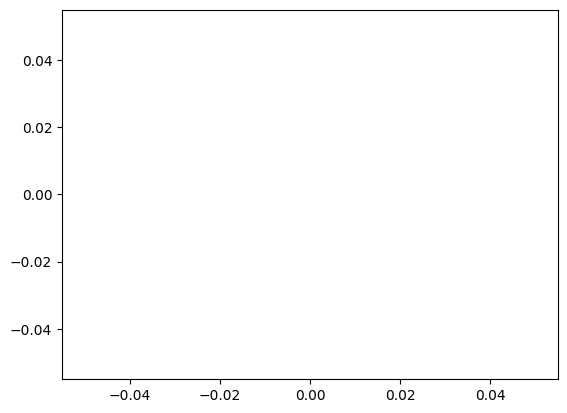

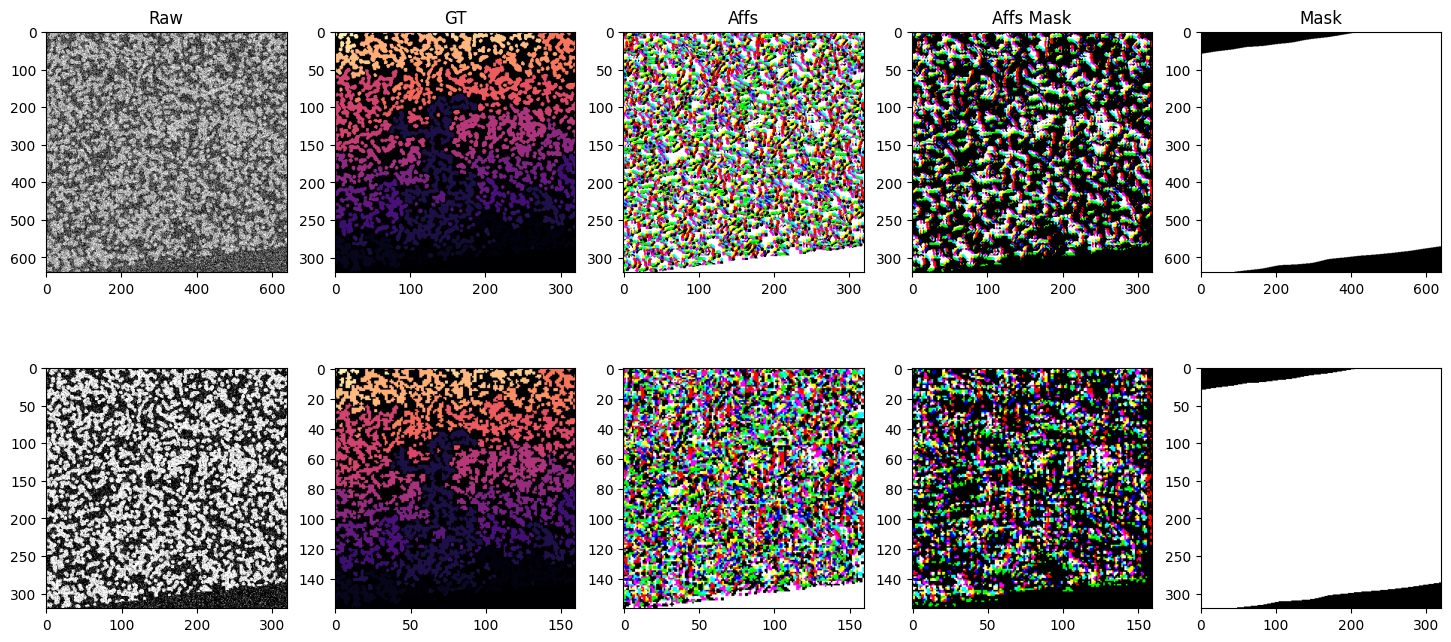

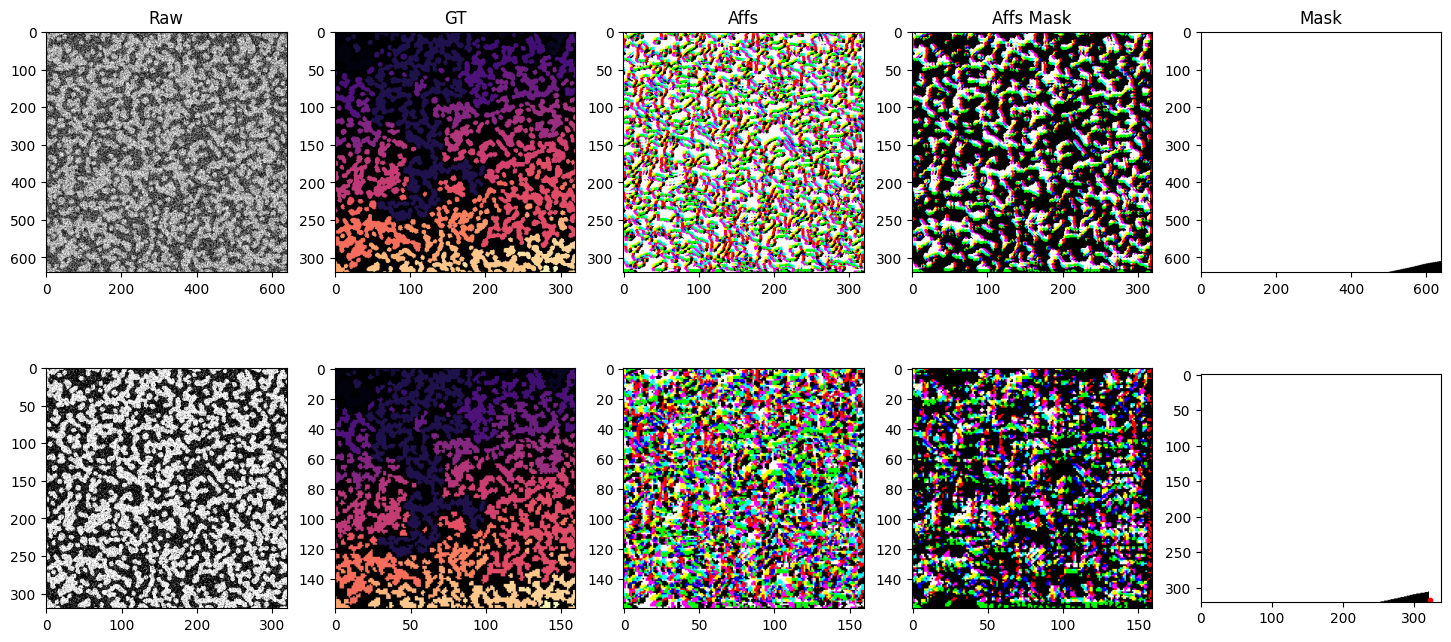

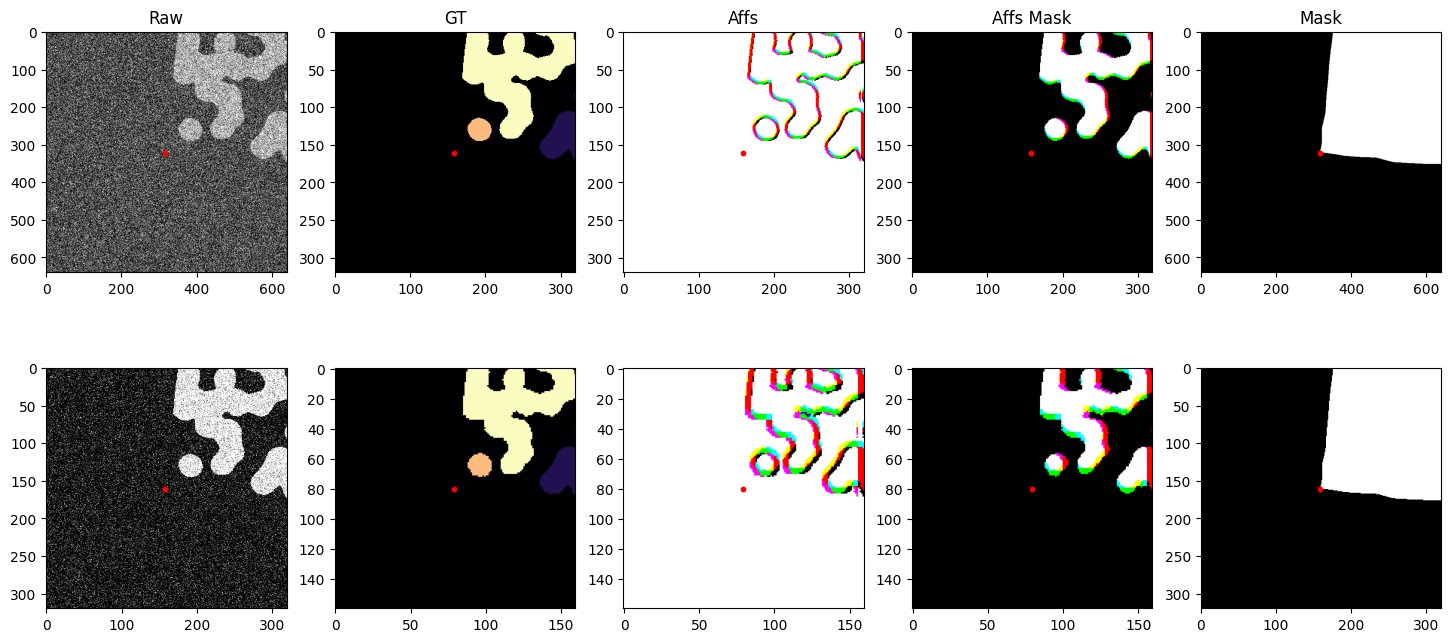

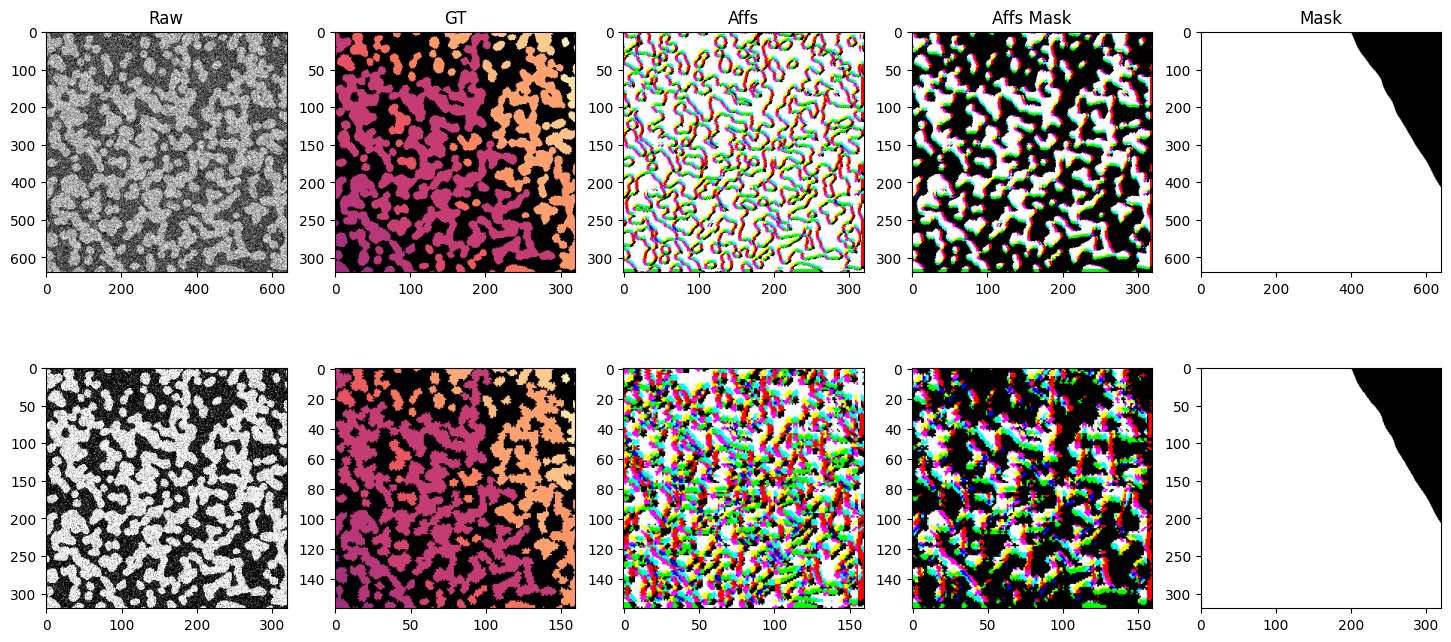

In [22]:
from dacapo_toolbox.dataset import (
    iterable_dataset,
    SimpleAugmentConfig,
    DeformAugmentConfig,
    MaskedSampling,
    PointSampling,
)
from dacapo_toolbox.transforms.affs import Affs, AffsMask
from funlib.persistence import Array
from skimage import data
from torchvision.transforms import v2 as transforms
import logging
import numpy as np
from skimage.measure import label

logging.basicConfig(level=logging.DEBUG)
# logging.getLogger("gunpowder.nodes.random_location").setLevel(logging.DEBUG)

side_length = 2048

# two different datasets with vastly different blob sizes
blobs_a = data.binary_blobs(
    length=side_length, blob_size_fraction=20 / side_length, n_dim=2
)
blobs_a_gt = label(blobs_a, connectivity=2)
blobs_b = data.binary_blobs(
    length=side_length, blob_size_fraction=100 / side_length, n_dim=2
)
blobs_b_gt = label(blobs_b, connectivity=2)
mask = np.ones((side_length, side_length), dtype=bool)
mask[side_length // 2 : side_length] = 0

# raw and gt arrays at various voxel sizes
raw_a_s0 = Array(blobs_a[::1, ::1], offset=(0, 0), voxel_size=(1, 1))
raw_a_s1 = Array(blobs_a[::2, ::2], offset=(0, 0), voxel_size=(2, 2))
raw_b_s0 = Array(blobs_b[::1, ::1], offset=(0, 0), voxel_size=(2, 2))
raw_b_s1 = Array(blobs_b[::2, ::2], offset=(0, 0), voxel_size=(4, 4))
gt_a_s0 = Array(blobs_a_gt[::2, ::2], offset=(0, 0), voxel_size=(2, 2))
gt_a_s1 = Array(blobs_a_gt[::4, ::4], offset=(0, 0), voxel_size=(4, 4))
gt_b_s0 = Array(blobs_b_gt[::2, ::2], offset=(0, 0), voxel_size=(4, 4))
gt_b_s1 = Array(blobs_b_gt[::4, ::4], offset=(0, 0), voxel_size=(8, 8))
mask_a = Array(mask, offset=(0, 0), voxel_size=(1, 1))
mask_b = Array(mask, offset=(0, 0), voxel_size=(2, 2))

g = nx.Graph()
g.add_nodes_from(
    [
        (i, {"position": position})
        for i, position in enumerate(
            [
                (side_length * 2 - 0.5, side_length * 2 - 0.5),
                (0.5, side_length * 2 - 0.5),
                (side_length * 2 - 0.5, 0.5),
                (0.5, 0.5),
            ]
        )
    ]
)

# defining the datasets
iter_ds = iterable_dataset(
    {
        "raw_s0": [raw_a_s0, raw_b_s0],
        "gt_s0": [gt_a_s0, gt_b_s0],
        "raw_s1": [raw_a_s1, raw_b_s1],
        "gt_s1": [gt_a_s1, gt_b_s1],
        "mask": [mask_a, mask_b],
        "mask_dummy": [mask_a, mask_b],
        "sample_points": [None, g],
    },
    shapes={
        "raw_s0": (128 * 5, 128 * 5),
        "gt_s0": (64 * 5, 64 * 5),
        "raw_s1": (64 * 5, 64 * 5),
        "gt_s1": (32 * 5, 32 * 5),
        "mask": (128 * 5, 128 * 5),
        "mask_dummy": (64 * 5, 64 * 5),
        "sample_points": (128 * 5, 128 * 5),
    },
    sampling_strategies=[
        MaskedSampling("mask_dummy", 0.8),
        PointSampling("sample_points"),
    ],
    transforms={
        ("raw_s0", "noisy_s0"): transforms.Compose(
            [transforms.ConvertImageDtype(), transforms.GaussianNoise(sigma=1.0)]
        ),
        ("raw_s1", "noisy_s1"): transforms.Compose(
            [transforms.ConvertImageDtype(), transforms.GaussianNoise(sigma=0.3)]
        ),
        ("gt_s0", "affs_s0"): Affs([[4, 0], [0, 4], [4, 4]]),
        ("gt_s0", "affs_mask_s0"): AffsMask([[4, 0], [0, 4], [4, 4]]),
        ("gt_s1", "affs_s1"): Affs([[4, 0], [0, 4], [4, 4]]),
        ("gt_s1", "affs_mask_s1"): AffsMask([[4, 0], [0, 4], [4, 4]]),
    },
    simple_augment_config=SimpleAugmentConfig(
        p=1.0, mirror_probs=[1.0, 0.0], transpose_only=[]
    ),
    deform_augment_config=DeformAugmentConfig(
        p=1.0,
        control_point_spacing=(10, 10),
        jitter_sigma=(5.0, 5.0),
        scale_interval=(0.5, 2.0),
        rotate=True,
    ),
)

import matplotlib.pyplot as plt

for i, batch in enumerate(iter_ds):
    print(f"Batch {i}")
    if i >= 4:  # Limit to 4 batches for demonstration
        break
    points = batch["sample_points"]
    xs = np.array([attrs["position"][0] for attrs in points.nodes.values()])
    ys = np.array([attrs["position"][1] for attrs in points.nodes.values()])
    plt.scatter(xs, ys, c="red", s=10)

    fig, axs = plt.subplots(2, 5, figsize=(18, 8))
    axs[0, 0].imshow(batch["noisy_s0"], cmap="gray")
    axs[0, 1].imshow(batch["gt_s0"], cmap="magma")
    axs[0, 2].imshow(batch["affs_s0"].permute(1, 2, 0).float())
    axs[0, 3].imshow(batch["affs_mask_s0"].permute(1, 2, 0).float())
    axs[0, 4].imshow(batch["mask"].float(), vmin=0, vmax=1, cmap="gray")
    axs[1, 0].imshow(batch["noisy_s1"], cmap="gray")
    axs[1, 1].imshow(batch["gt_s1"], cmap="magma")
    axs[1, 2].imshow(batch["affs_s1"].permute(1, 2, 0).float())
    axs[1, 3].imshow(batch["affs_mask_s1"].permute(1, 2, 0).float())
    axs[1, 4].imshow(batch["mask"][::2, ::2].float(), vmin=0, vmax=1, cmap="gray")
    for a, b in product(range(2), range(5)):
        s = 2 ** (a + (b % 4 != 0))
        axs[a, b].scatter(ys / s, xs / s, c="red", s=10)

    axs[0, 0].set_title("Raw")
    axs[0, 1].set_title("GT")
    axs[0, 2].set_title("Affs")
    axs[0, 3].set_title("Affs Mask")
    axs[0, 4].set_title("Mask")

    plt.savefig(out_ds / f"affs_batch_{i}.png")

Visualize the batches:
![Affs Batch 0](_static/dataset_overview/affs_batch_0.png)
![Affs Batch 1](_static/dataset_overview/affs_batch_1.png)
![Affs Batch 2](_static/dataset_overview/affs_batch_2.png)
![Affs Batch 3](_static/dataset_overview/affs_batch_3.png)